In [1]:
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import simpleaudio as sa
from scipy.io import wavfile

In [2]:
def PrintArrayInfo(a,name=''):
    if (len(name)==0):
        print("Array info:")
    else:
        print("Array:", name)
    print("shape:", a.shape)
    print("dtype:", a.dtype)
    print("min, max:", a.min(), a.max())
    print()

### Loading an audio file of a C note on piano:

In [3]:
filename = 'c.wav'
wave_obj = sa.WaveObject.from_wave_file(filename)
play_obj = wave_obj.play()
play_obj.wait_done()  # Wait until sound has finished playing

### Plotting the audio formation:

Data rate [units of Hz = 1/seconds] =  44100
Array: data
shape: (111210,)
dtype: int16
min, max: -4170 4096



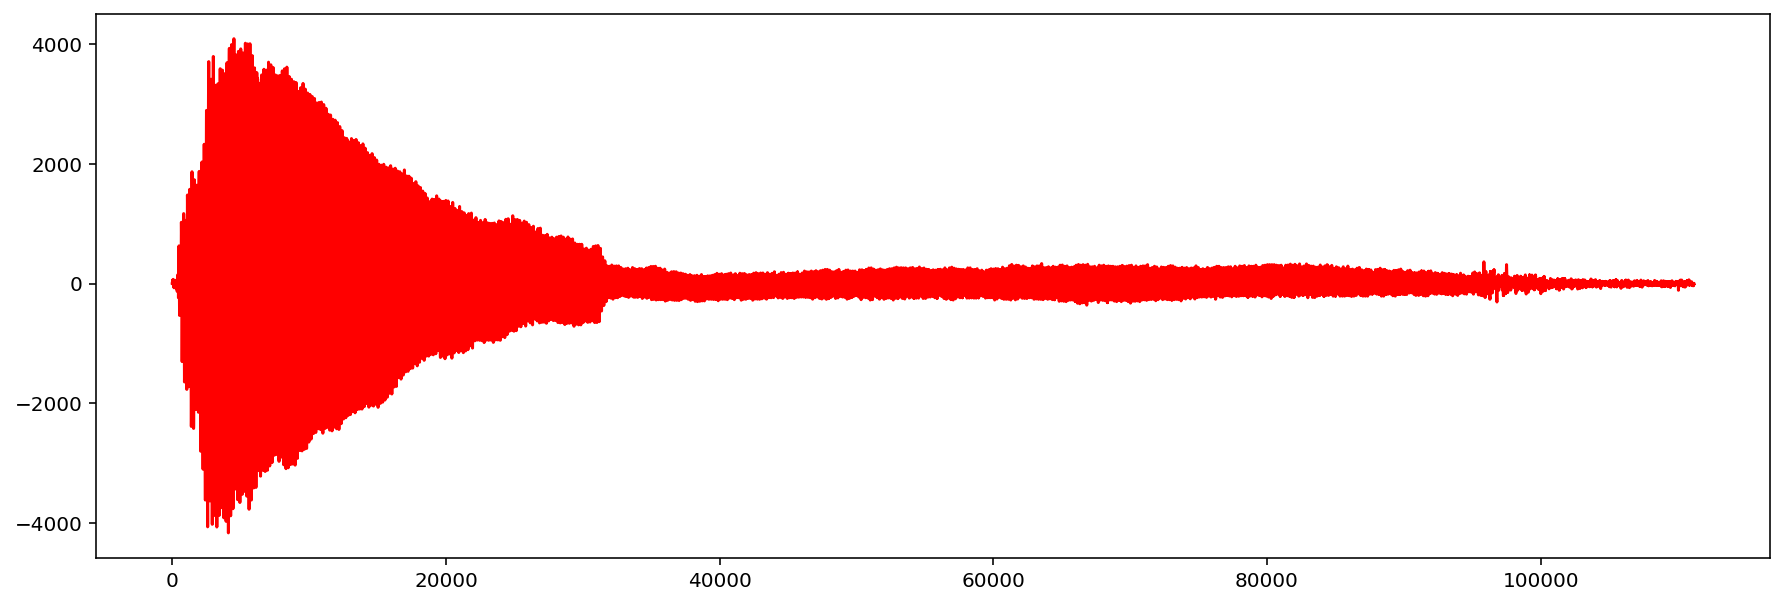

In [4]:
from scipy.io import wavfile

# Load data from wav file
rate, c_data = wavfile.read('c.wav')

print("Data rate [units of Hz = 1/seconds] = ",rate)
PrintArrayInfo(c_data,"data")

plt.rcParams['figure.figsize'] = [15, 5]
plt.plot(c_data,'r-')
plt.show()

### Using Fourier Transform to identify the frequencies in a C note on piano:

In [5]:
import math
from math import pi
def fourier_sum(dataset, k):
    n = len(dataset)
    
    f_k_sin = 0
    f_k_cos = 0
    
    for j in range(n):
        f_k_sin += dataset[j] * np.sin((2 * pi * j * k) / n)
        f_k_cos += dataset[j] * np.cos((2 * pi * j * k) / n)
        
    return f_k_sin**2 + f_k_cos**2

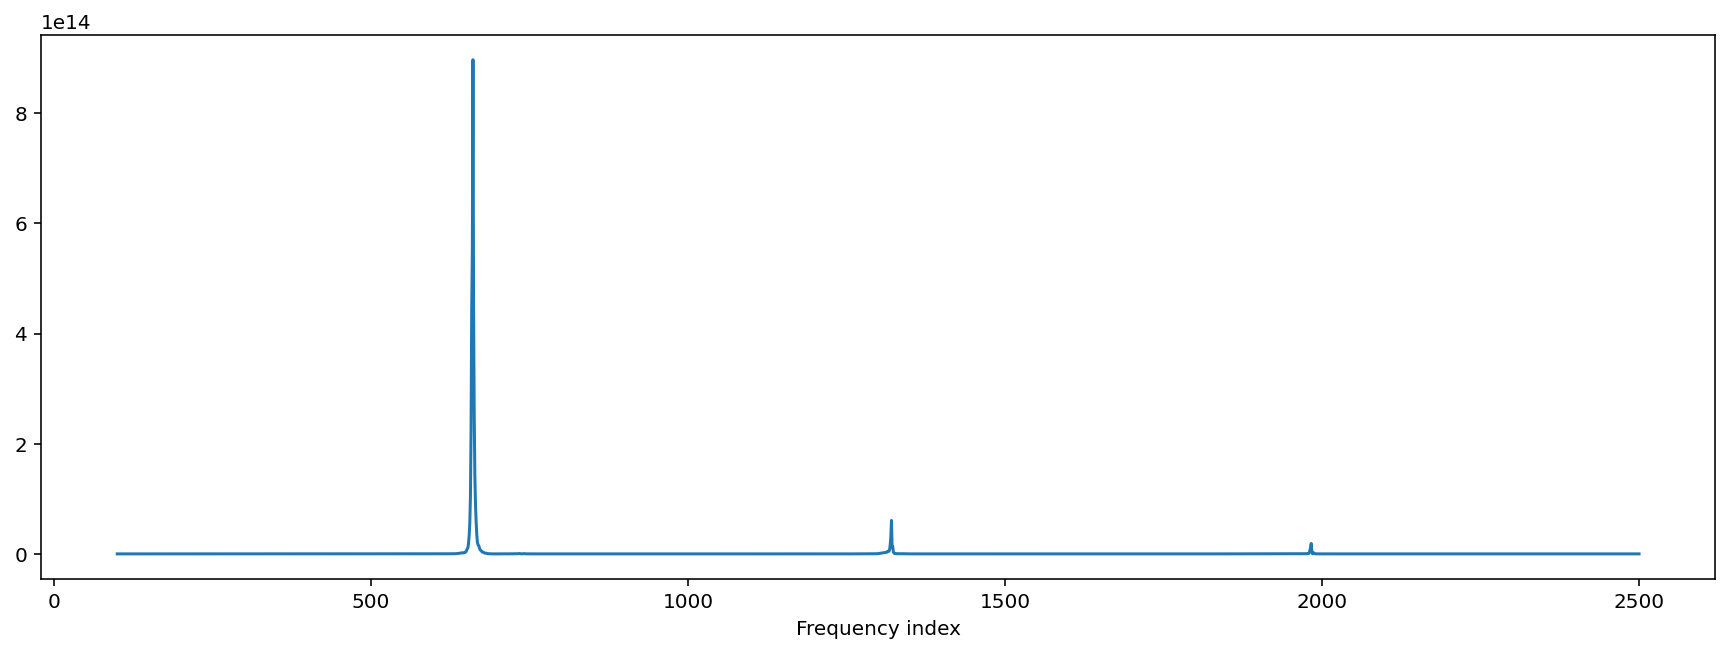

In [6]:
k1 = 100
k2 = 2500
frequency_indices = np.arange(k1, k2 + 1)
fourier_sum_results = fourier_sum(c_data, frequency_indices)

plt.plot(frequency_indices, fourier_sum_results)
plt.xlabel('Frequency index')
plt.show()

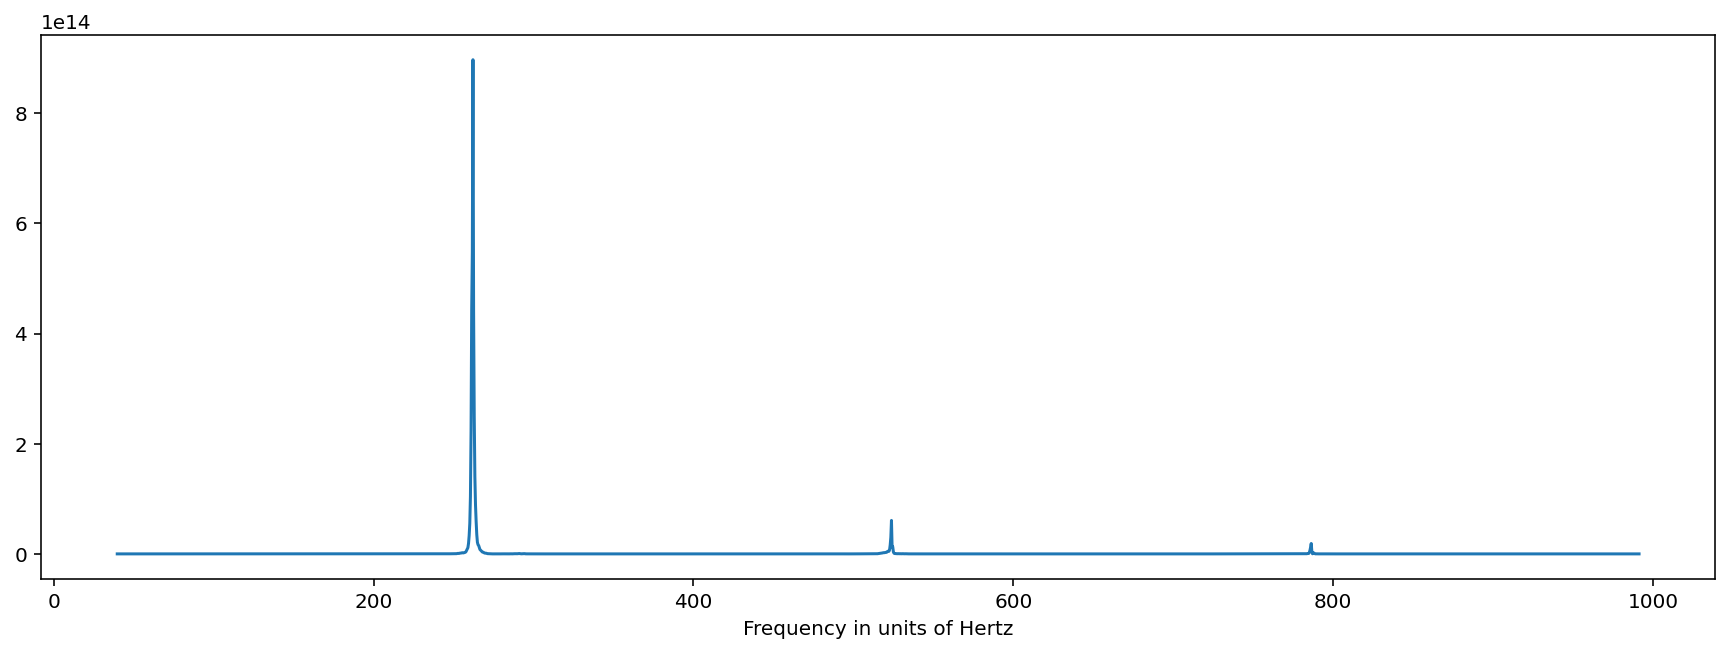

In [7]:
frequency_hertz = (frequency_indices * 44100) /len(c_data)
plt.plot(frequency_hertz, fourier_sum_results)
plt.xlabel('Frequency in units of Hertz')
plt.show()

### Identifying the dominant frequencies:

In [8]:
i = 100
dominant_frequencies = []
while i < 2400:
    if fourier_sum_results[i] > 0.1 * 1e14:
        dominant_frequencies.append((i * 44100) / len(c_data))
    i += 1
print(dominant_frequencies)

[219.29053142702995, 219.68707850013487, 220.08362557323983, 220.48017264634476, 220.87671971944968, 221.27326679255464, 221.66981386565956, 222.0663609387645, 222.46290801186944, 222.85945508497437, 223.2560021580793, 223.65254923118425, 224.04909630428918, 224.4456433773941, 224.84219045049906, 225.238737523604, 225.63528459670894, 226.03183166981387, 226.4283787429188, 483.3908821149177, 483.78742918802266, 484.1839762611276, 484.5805233342325, 484.97707040733746, 746.3015915834907, 746.6981386565956]


Let us take the following dominant frequencies:

223.2560021580793 Hz

484.1839762611276 Hz

746.6981386565956 Hz

### Calculating the ratios of the frequencies relative to the fundamental frequency:

In [9]:
484.1839762611276 / 223.2560021580793

2.168738898756661

In [10]:
746.6981386565956 / 223.2560021580793

3.344582593250444

### Calculating the ratios of amplitudes of the frequencies relative to the fundamental frequency:

In [11]:
i = 100
dominant_frequency_amplitudes = []
while i < 2400:
    if fourier_sum_results[i] > 0.1 * 1e14:
        if (i * 44100) / len(c_data) == 223.2560021580793 or (i * 44100) / len(c_data) == 484.1839762611276 or (i * 44100) / len(c_data) == 746.6981386565956:
            dominant_frequency_amplitudes.append(fourier_sum_results[i])
    i += 1
print(sorted(dominant_frequency_amplitudes, reverse=True))

[249259343118354.28, 60740743945675.5, 18875807674602.824]


In [12]:
60740743945675.5 / 249259343118354.28

0.24368492344471254

In [13]:
18875807674602.824 / 249259343118354.28

0.07572758332128052

### Construct a C piano note ourselves now using the C frequency we know:

In [78]:
C_freq   = 256
fs        = 44100  # 44100 samples per second
seconds   = 1      # Duration of 1 second

# Generate array with seconds * sample_rate steps
t = np.linspace(0, seconds, seconds * fs, False)

# Generate a sine wave
note = np.sin(C_freq * t * 2 * np.pi)

note += (np.sin((C_freq * 2 ** (12 / 12)) * t * 2 * np.pi) * 0.24368492344471254)

note += (np.sin((C_freq * 2 ** (24 / 12)) * t * 2 * np.pi) * 0.07572758332128052)

# Ensure that highest value is in 16-bit range
C_audio = note * (2**15 - 1) / np.max( np.abs(note) )

C_audio = C_audio[:len(C_audio) // 2]

In [79]:
len(C_audio)

22050

In [80]:
point_five_mark = len(C_audio) - (44100 / 3)

i = len(C_audio)
while i >= point_five_mark:
    C_audio[i:] = np.array(C_audio[i:] * 0.9, dtype=np.int16)
    i -= 1000
    
i = 1
while i < (44100/8):
    C_audio[:i] = np.array(C_audio[:i] * 0.9, dtype=np.int16)
    i += 1000

# C_audio = C_audio[:35000]

# Convert to 16-bit data
C_audio = C_audio.astype(np.int16)

# Start playback
play_obj = sa.play_buffer(C_audio, 1, 2, fs)

# Wait for playback to finish before exiting
play_obj.wait_done()

### Construct other piano notes in the A minor scale:

In [81]:
def construct_audio(k):
    freq   = 256 * 2 ** (k/12)
    fs        = 44100  # 44100 samples per second
    seconds   = 1      # Duration of 1 second

    # Generate array with seconds * sample_rate steps
    t = np.linspace(0, seconds, seconds * fs, False)

    # Generate a sine wave
    note = np.sin(freq * t * 2 * np.pi)

    note += (np.sin((freq * 2 ** (12 / 12)) * t * 2 * np.pi) * 0.24368492344471254)

    note += (np.sin((freq * 2 ** (24 / 12)) * t * 2 * np.pi) * 0.07572758332128052)

    # Ensure that highest value is in 16-bit range
    audio = note * (2**15 - 1) / np.max( np.abs(note) )
    
    audio = audio[:len(audio) // 2]
    
    point_five_mark = len(audio) - (44100 / 3)

    i = len(audio)
    while i >= point_five_mark:
        audio[i:] = np.array(audio[i:] * 0.9, dtype=np.int16)
        i -= 1000

    i = 1
    while i < (44100/8):
        audio[:i] = np.array(audio[:i] * 0.9, dtype=np.int16)
        i += 1000

    #audio = audio[:35000]

    # Convert to 16-bit data
    audio = audio.astype(np.int16)
    
    return audio

In [82]:
D_audio = construct_audio(2)
E_audio = construct_audio(4)
F_audio = construct_audio(5)
G_audio = construct_audio(7)
A_audio = construct_audio(9)
B_audio = construct_audio(11)
C1_audio = construct_audio(12)
D1_audio = construct_audio(14)
E1_audio = construct_audio(16)
F1_audio = construct_audio(17)
G1_audio = construct_audio(19)
A1_audio = construct_audio(21)
B1_audio = construct_audio(23)
C2_audio = construct_audio(24)

In [83]:
note_map = {'C': C_audio, 'D': D_audio,'E': E_audio, 
            'F': F_audio,  'G': G_audio, 'A': A_audio,
            'B': B_audio, 'C1': C1_audio, 'D1': D1_audio,
            'E1': E1_audio, 'F1': F1_audio, 'G1': G1_audio,
            'A1': A1_audio, 'B1': B1_audio, 'C2': C2_audio
           }

notes = ['C', 'D','E', 'F', 'G', 'A','B',
        'C1', 'D1', 'E1', 'F1', 'G1', 'A1',
        'B1', 'C2']

### Use a random walk to generate and play a musical tune, starting on the A note:

In [193]:
audio = A_audio.copy()

index = 5

count = 1

tune = ['A']

while count <= 20:
    r = np.random.rand()
    
    if r < 0.125:
        index = max(0, index - 1)
    elif r < 0.25:
        index = max(0, index - 2)
    elif r < 0.375:
        index = max(0, index - 3)
    elif r < 0.5:
        index = max(0, index - 4)
    elif r < 0.625:
        index = index
    elif r < 0.75:
        index = min(len(notes) - 1, index + 2)
    elif r < 0.875:
        index = min(len(notes) - 1, index + 2)
    elif r < 1:
        index = min(len(notes) - 1, index + 1)

    audio = np.concatenate((audio, note_map[notes[index]]))
    tune.append(notes[index])
    count += 1

In [194]:
wavfile.write('music.mp3', 44100, audio)

In [195]:
# Start playback
play_obj = sa.play_buffer(audio, 1, 2, fs)

# Wait for playback to finish before exiting
play_obj.wait_done()

### Generate an animation visualizing the tune:

In [196]:
note_level_map = {'A': 0, 'B': 0.5, 'C1': 1, 'D1': 1.5, 'E1': 2, 'F1': 2.5, 'G1': 3, 'A1': 3.5, 'B1': 4, 'C2': 4.5,
                 'G': -0.5, 'F': -1, 'E': -1.5, 'D': -2, 'C': -2.5}

In [197]:
tune_levels = [note_level_map[i] for i in tune]

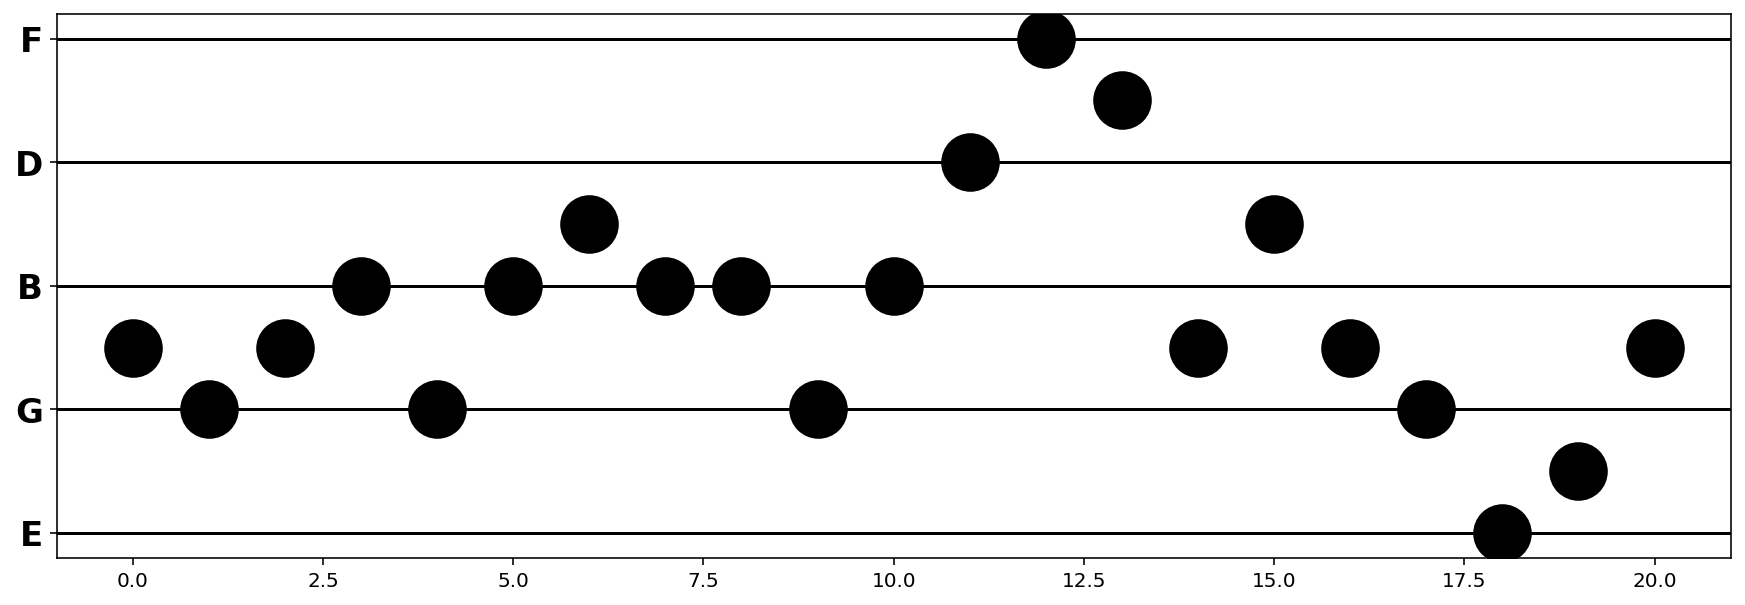

In [200]:
import matplotlib.cm as cm
import matplotlib.animation as animation

frames = [] # for storing the generated images
fig = plt.figure()
plt.axhline(0.5, color='black', linestyle = '-')
plt.axhline(1.5, color='black', linestyle = '-')
plt.axhline(2.5, color='black', linestyle = '-')
plt.axhline(-0.5, color='black', linestyle = '-')
plt.axhline(-1.5, color='black', linestyle = '-')
plt.xlim(-1, 21)
plt.yticks([-1.5, -0.5, 0.5, 1.5, 2.5], ['E', 'G', 'B', 'D', 'F'], color='black', fontweight='bold', fontsize='17', horizontalalignment='right')

for i in range(len(tune_levels)):
    frames.append([plt.scatter(range(len(tune_levels[:i+1])), tune_levels[:i+1], color='black',s=800)])        

ani = animation.ArtistAnimation(fig, frames, interval=500, blit=True,
                                repeat_delay=1000)
ani.save('music_animation.mp4')
plt.show()